In [229]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt

# I. Trial simple case

In [230]:
x1=np.array([[1,2],[3,8],[5,6]])
x2=np.array([[25,9],[19,26],[23,16],[27,45]])

In [231]:
np.cov(x2.T)

array([[ 11.66666667,  15.33333333],
       [ 15.33333333, 244.66666667]])

In [232]:
class Bayes_classifier:
    def __init__(self,X):
        self.K=len(X)
        self.D=X[0].shape[-1]
        self.X=X
    def fit(self):
        self.py=np.zeros(self.K)
        self.mu=np.zeros([self.K,self.D])
        self.cov=np.zeros([self.K,self.D,self.D])
        sample_num=[len(x) for x in self.X]
        for idx,x in enumerate(self.X):
            self.mu[idx]=x.mean(axis=0)
            self.cov[idx]=np.cov(x.T)
            self.py[idx]=len(x)/sum(sample_num)
    def sample_method1(self,k):
        return mvn.rvs(self.mu[k],self.cov[k])
    def sample_method2(self):
        k=np.random.choice(self.K,p=self.py)
        print(k)
        return k,mvn.rvs(self.mu[k],self.cov[k])
    def classify(self,x):
        posterior_numerator=np.zeros(self.K)
        for k,_ in enumerate(self.X):
            posterior_numerator[k]=np.log(mvn.pdf(x,self.mu[k],self.cov[k]))+np.log(self.py[k])
        plt.scatter(x[0],x[1],marker='^',c='r',label='New data point')
        self.plot_scatter()
        return posterior_numerator,np.argmax(posterior_numerator)
    def plot_scatter(self):
        Xarray=np.array([])
        for k,x in enumerate(self.X):
            plt.scatter(x[:,0],x[:,1],label='Class '+str(k+1))
            plt.scatter(self.mu[k,0],self.mu[k,1],label='Mean '+str(k+1))
            Xarray=np.vstack([Xarray,x]) if Xarray.size else x
        plt.xlim(Xarray.min()-2,Xarray.max()+2)
        plt.ylim(Xarray.min()-2,Xarray.max()+2)
        plt.legend()
        


In [233]:
BC=Bayes_classifier([x1,x2])

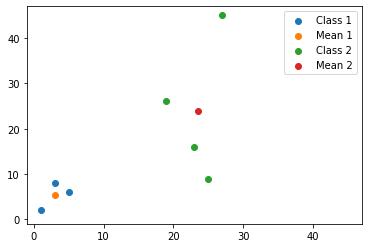

In [234]:
BC.fit()
BC.plot_scatter()

In [235]:
BC.sample_method2()

0


(0, array([-0.08893032, -0.80162355]))

(array([-27.35072699, -27.45394902]), 0)

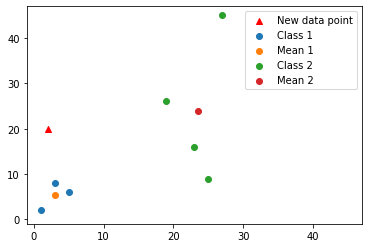

In [236]:
BC.classify(np.array([2,20]))

In [237]:
np.linalg.norm(BC.mu-np.array([2,30]),axis=0)

array([21.52324325, 25.38591035])

# II Mnist data set

In [238]:
import util
X, Y = util.get_mnist()

Reading in and transforming data...


In [239]:
class Bayes_classifier_renew:
    def __init__(self,X,Y):
        self.K=len(set(Y))
        self.D=X.shape[-1]
        #self.X=X
    def fit(self,X,Y):
        self.py=np.zeros(self.K)
        self.mu=np.zeros([self.K,self.D])
        self.cov=np.zeros([self.K,self.D,self.D])
        sample_num=X.shape[0]
        for k in range(self.K):
            xk=X[Y==k]
            self.mu[k]=xk.mean(axis=0)
            self.cov[k]=np.cov(xk.T)
            self.py[k]=xk.shape[0]/sample_num
    def sample_method1(self,k):
        return mvn.rvs(self.mu[k],self.cov[k])
    def sample_method2(self):
        k=np.random.choice(self.K,p=self.py)
        print(k)
        return k,mvn.rvs(self.mu[k],self.cov[k])
    def classify(self,x):
        posterior_numerator=np.zeros(self.K)
        for k in range(self.K):
            posterior_numerator[k]=np.log(mvn.pdf(x,self.mu[k],self.cov[k]))+np.log(self.py[k])
        return posterior_numerator,np.argmax(posterior_numerator)


In [240]:
BC=Bayes_classifier_renew(X,Y)
BC.fit(X,Y)

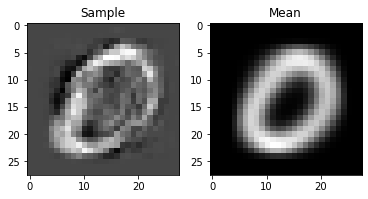

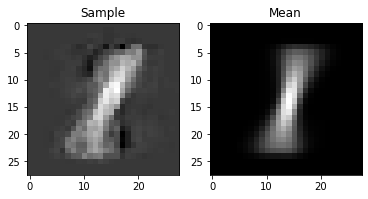

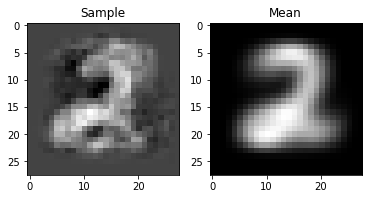

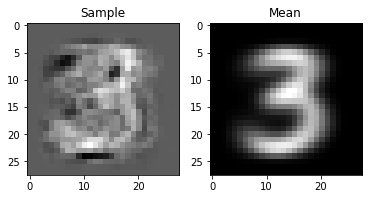

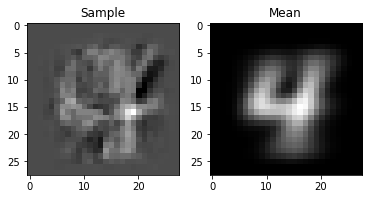

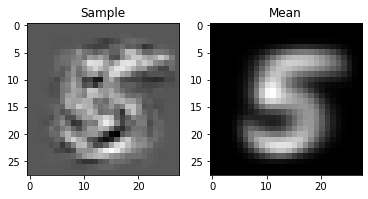

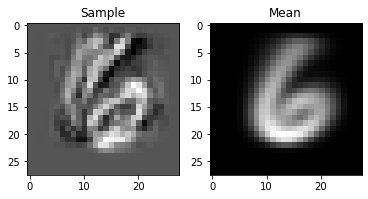

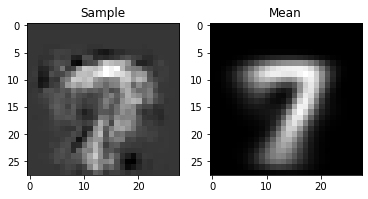

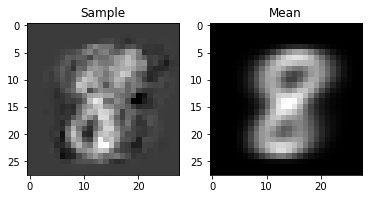

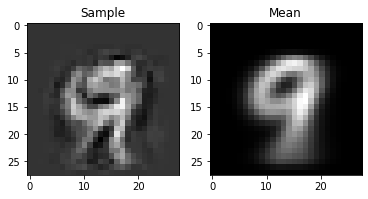

In [241]:
for k in range(BC.K):
  # show one sample for each class
  # also show the mean image learned

  sample = BC.sample_method1(k).reshape(28, 28)
  mean = BC.mu[k].reshape(28, 28)

  plt.subplot(1,2,1)
  plt.imshow(sample, cmap='gray')
  plt.title("Sample")
  plt.subplot(1,2,2)
  plt.imshow(mean, cmap='gray')
  plt.title("Mean")
  plt.show()

2


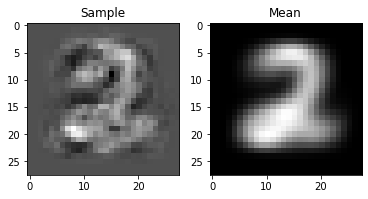

0


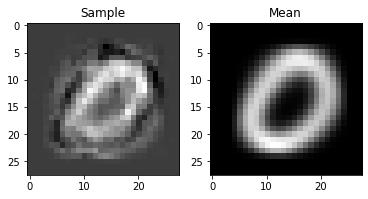

7


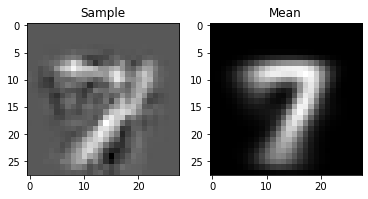

4


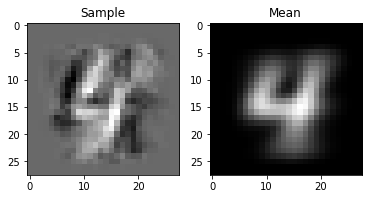

5


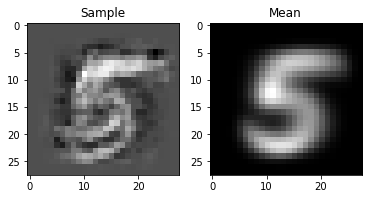

In [242]:
for k in range(5):
  # show one sample for each class
  # also show the mean image learned

  k,sample = BC.sample_method2()
  sample=sample.reshape(28, 28)
  mean = BC.mu[k].reshape(28, 28)

  plt.subplot(1,2,1)
  plt.imshow(sample, cmap='gray')
  plt.title("Sample")
  plt.subplot(1,2,2)
  plt.imshow(mean, cmap='gray')
  plt.title("Mean")
  plt.show()

# III. The variational GMM

In [243]:
from sklearn.mixture import BayesianGaussianMixture as Var_GMM

In [244]:
class Bayes_classifier_GMM:
    def __init__(self,X,Y):
        self.K=len(set(Y))
        self.D=X.shape[-1]
        #self.X=X
    def fit(self,X,Y):
        self.py=np.zeros(self.K)
        self.GMMs={}
        #self.mu=np.zeros([self.K,self.D])
        #self.cov=np.zeros([self.K,self.D,self.D])
        
        sample_num=X.shape[0]
        for k in range(self.K):
            VI_GMM=Var_GMM(n_components=4)
            xk=X[Y==k]
            #self.mu[k]=xk.mean(axis=0)
            #self.cov[k]=np.cov(xk.T)
            self.py[k]=xk.shape[0]/sample_num
            self.GMMs[k]=VI_GMM.fit(xk)
    def sample_method1(self,k):
        return self.GMMs[k].sample()
    def sample_method2(self):
        k=np.random.choice(self.K,p=self.py)
        print(k)
        return self.GMMs[k].sample()
    def classify(self,x):
        posterior_numerator=np.zeros(self.K)
        for k in range(self.K):
            posterior_numerator[k]=self.GMMs[k].score(x)+np.log(self.py[k])
        return posterior_numerator,np.argmax(posterior_numerator)

In [245]:
BC=Bayes_classifier_GMM(X,Y)
BC.fit(X,Y)

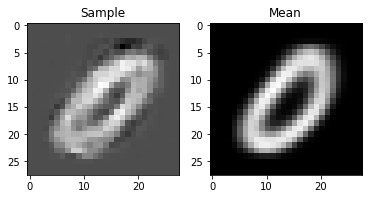

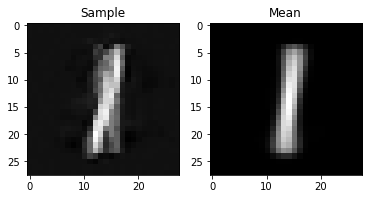

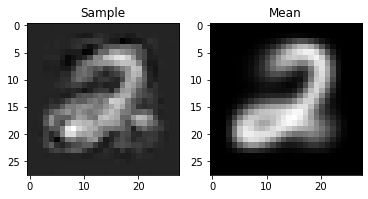

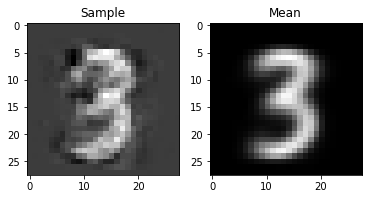

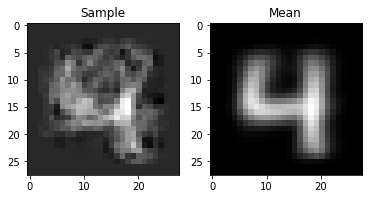

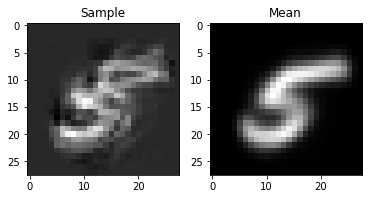

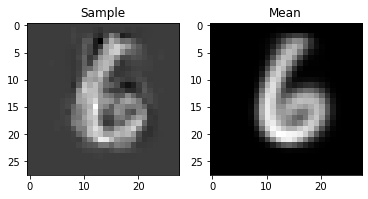

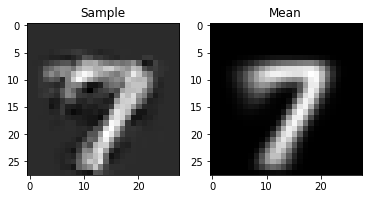

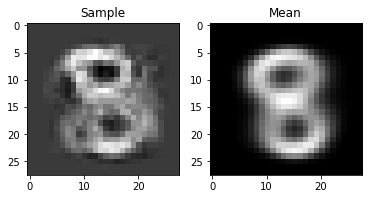

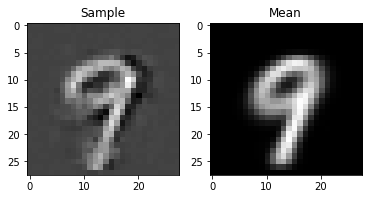

In [246]:
for k in range(BC.K):
  # show one sample for each class
  # also show the mean image learned

  sample,cluster = BC.sample_method1(k)
  sample = sample.reshape(28, 28)
  #mean = BC.mu[k].reshape(28, 28)
  mean=BC.GMMs[k].means_[cluster].reshape(28, 28)

  plt.subplot(1,2,1)
  plt.imshow(sample, cmap='gray')
  plt.title("Sample")
  plt.subplot(1,2,2)
  plt.imshow(mean, cmap='gray')
  plt.title("Mean")
  plt.show()

# The simple Auto encoder

In [248]:
import util
import torch
import torch.nn as nn
X, Y = util.get_mnist()

Reading in and transforming data...


In [249]:
X_torch=torch.Tensor(X)

In [832]:
import math as m
class Auto_encoder:
    def __init__(self,X,hidden_size):
        self.D=X.shape[-1]
        self.W1=torch.randn([self.D,hidden_size])*m.sqrt(2/hidden_size)#/hidden_size#
        self.b1=torch.zeros(hidden_size)
        self.W2=torch.randn([hidden_size,self.D])*m.sqrt(2/self.D)#/self.D#
        self.b2=torch.zeros(self.D)

    def forward(self,X):
        self.z=torch.relu(X@self.W1+self.b1)
        #print('z:',self.z)
        #z=X@self.W1+self.b1
        #nn.ReLU()
        output=torch.sigmoid(self.z@self.W2+self.b2)
        #print('output:',output)
        #output=z@self.W2+self.b2
        return output
    
    def pseudo_MSE_cost(self,output,Y):
        return 1/(Y.shape[0])*((output-Y)**2).sum()
    
    def require_grad(self,grad=True):
        self.W1.requires_grad=grad
        self.b1.requires_grad=grad
        self.W2.requires_grad=grad
        self.b2.requires_grad=grad
    def fit(self,X,Y,lr=0.001,max_iter=100):
        costs=[]
        self.require_grad()
        #loss=nn.BCELoss()
        for i in range(max_iter):
            output=self.forward(X)
            #cost=loss(output,Y)
            cost=self.pseudo_MSE_cost(output,Y)
            cost.backward()
            #print('W1_11:',self.W1[0,0].detach())
            #print('Grad_W1:',self.W1.grad)
            with torch.no_grad():
                self.W1-=(lr*self.W1.grad)
                self.W2-=(lr*self.W2.grad)
                self.b1-=(lr*self.b1.grad)
                self.b2-=(lr*self.b2.grad)
                self.W1.grad.zero_()
                self.W2.grad.zero_()
                self.b1.grad.zero_()
                self.b2.grad.zero_()
            costs.append(cost.detach())
        plt.plot(costs)
        plt.xlabel('Iteration')
        plt.ylabel('MSE loss')
    def fit_batch(self,X,Y,lr=0.01,max_epoch=30,batch_size=64,decay=False,min_lr=1e-5,decay_rate=0.99):
        costs=[]
        self.require_grad()
        loss=nn.MSELoss()
        num_bt=int(X.shape[0]/batch_size)
        for i in range(max_epoch):
            for j in range(num_bt):
                X_b=X[j*batch_size:(j+1)*batch_size]
                Y_b=Y[j*batch_size:(j+1)*batch_size]
                output=self.forward(X_b)
                #cost=loss(output,Y_b)
                cost=self.pseudo_MSE_cost(output,Y_b)
                cost.backward()
                with torch.no_grad():
                    self.W1-=(lr*self.W1.grad)
                    self.W2-=(lr*self.W2.grad)
                    self.b1-=(lr*self.b1.grad)
                    self.b2-=(lr*self.b2.grad)
                    self.W1.grad.zero_()
                    self.W2.grad.zero_()
                    self.b1.grad.zero_()
                    self.b2.grad.zero_()
                if decay:
                    if lr>min_lr:
                        lr*=decay_rate
                costs.append(cost.detach())
        plt.plot(costs)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
    def sample(self,X):
        idx=np.random.choice(X.shape[0])
        Xs=X[idx]
        #print('The data:',Xs)
        with torch.no_grad():
            output=self.forward(Xs)
            output=output.reshape(28, 28)
        plt.subplot(1,2,1)
        plt.imshow(Xs.reshape(28,28), cmap='gray')
        plt.title("Original")
        plt.subplot(1,2,2)
        plt.imshow(output, cmap='gray')
        plt.title("Reconstruction")
        #return output
        
        


AE=Auto_encoder(X_torch,300)
AE.fit(X_torch,X_torch)

AE.sample(X_torch)

AE.forward(X_torch[9])

AE.require_grad()
#AE.forward(X_torch).unique()

cost=AE.MSE_cost(AE.forward(X_torch),X_torch)
print(cost)
cost.backward()

with torch.no_grad():
    #print(AE.W1.detach())
    print(AE.W2.grad.unique())
    #AE.W1-=(0.01*AE.W1.grad)
    #print(AE.W1.detach())

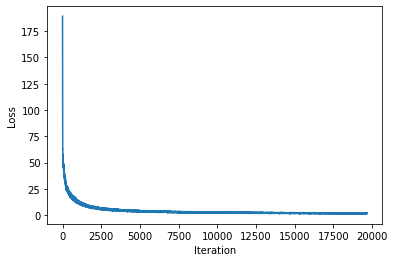

In [833]:
AE=Auto_encoder(X_torch,300)
AE.fit_batch(X_torch,X_torch,batch_size=64)

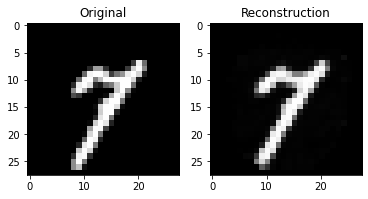

In [849]:
AE.sample(X_torch)

42000

# Extra: Auto-encoder by Pytorch build-in

In [745]:
from torch import optim
from torch.nn import MSELoss,BCEWithLogitsLoss,BCELoss
import math as m

In [898]:

class Auto_encoder_0628:
    def __init__(self,X,hidden_size):
        self.D=X.shape[-1]
        self.W1=torch.randn([self.D,hidden_size])*m.sqrt(2/hidden_size)
        self.b1=torch.zeros(hidden_size)
        self.W2=torch.randn([hidden_size,self.D])*m.sqrt(2/self.D)
        self.b2=torch.zeros(self.D)

    def forward(self,X):
        self.z=torch.relu(X@self.W1+self.b1)
        output=torch.sigmoid(self.z@self.W2+self.b2)
        return output
    
    def require_grad(self,grad=True):
        self.W1.requires_grad=grad
        self.b1.requires_grad=grad
        self.W2.requires_grad=grad
        self.b2.requires_grad=grad
    
    def fit_batch(self,X,eta=0.1,max_epoch=30,\
        batch_size=64,decay=False,min_lr=1e-5,decay_rate=0.99,Lfn=BCELoss()):
        costs=[]
        self.require_grad()
        optimizer = optim.SGD([self.W1,self.b1,self.W2,self.b2], lr=eta, momentum=0.9, 
                      weight_decay=0.0005)
        loss=Lfn
        num_bt=int(X.shape[0]/batch_size)
        for i in range(max_epoch):
            X=X[torch.randperm(X.size()[0])]
            for j in range(num_bt):
                X_b=X[j*batch_size:(j+1)*batch_size]
                output=self.forward(X_b)
                cost=loss(output,X_b)
                optimizer.zero_grad()
                cost.backward()
                optimizer.step()
                if decay:
                    if eta>min_lr:
                        eta*=decay_rate
                costs.append(cost.detach())
        plt.plot(costs)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        
    def sample(self,X):
        idx=np.random.choice(X.shape[0])
        Xs=X[idx]
        #print('The data:',Xs)
        with torch.no_grad():
            output=self.forward(Xs)
            output=output.reshape(28, 28)
        plt.subplot(1,2,1)
        plt.imshow(Xs.reshape(28,28), cmap='gray')
        plt.title("Original")
        plt.subplot(1,2,2)
        plt.imshow(output, cmap='gray')
        plt.title("Reconstruction")
        #return output

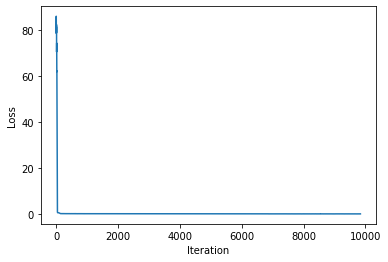

In [934]:
AE_=Auto_encoder_0628(X_torch,300)
AE_.fit_batch(X_torch,batch_size=64,max_epoch=15,decay=True)

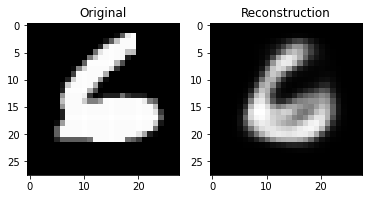

In [940]:
AE_.sample(X_torch)